In [1]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2
import os

import cv2 as cv
import numpy as np
np.set_printoptions(suppress=True, precision=4)
import shutil
import numpy as np
import pandas as pd
import albumentations as A

from PIL import Image, ImageDraw
#from ultralytics import YOLO

from utils.utils import list_file_r, copy_image_to_sub_dir
from utils.data_augmentation import batch_augment_with_bbox, batch_augment_with_mask, batch_invers_FDA

In [ ]:
import matplotlib.pyplot as plt

from skimage import data
from skimage import color
from skimage import morphology
from skimage import segmentation

# Input data
img = cv.imread('datasets/CF_simulation/images/01_line_Radius4_2_Density1500_1000_Width50_Reflection_0.tif')
# Compute a mask
lum = color.rgb2gray(img)
mask = morphology.remove_small_holes(
    morphology.remove_small_objects(
        lum < 0.7, 500),
    500)

mask = morphology.opening(mask, morphology.disk(3))

# result
#res = segmentation.slic(img, n_segments=200, start_label=1, compactness=20)
res = segmentation.watershed(img, compactness=20)

# Display result
fig, ax_arr = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10, 10))
ax1, ax2, ax3, ax4 = ax_arr.ravel()

ax1.imshow(img)
ax1.set_title('Original image')

ax2.imshow(mask, cmap='gray')
ax2.set_title('Mask')

#ax3.imshow(segmentation.mark_boundaries(img, res))
#ax3.contour(mask, colors='red', linewidths=1)
ax3.imshow(res)
ax3.set_title('SLIC')
for ax in ax_arr.ravel():
    ax.set_axis_off()

plt.tight_layout()
plt.show()

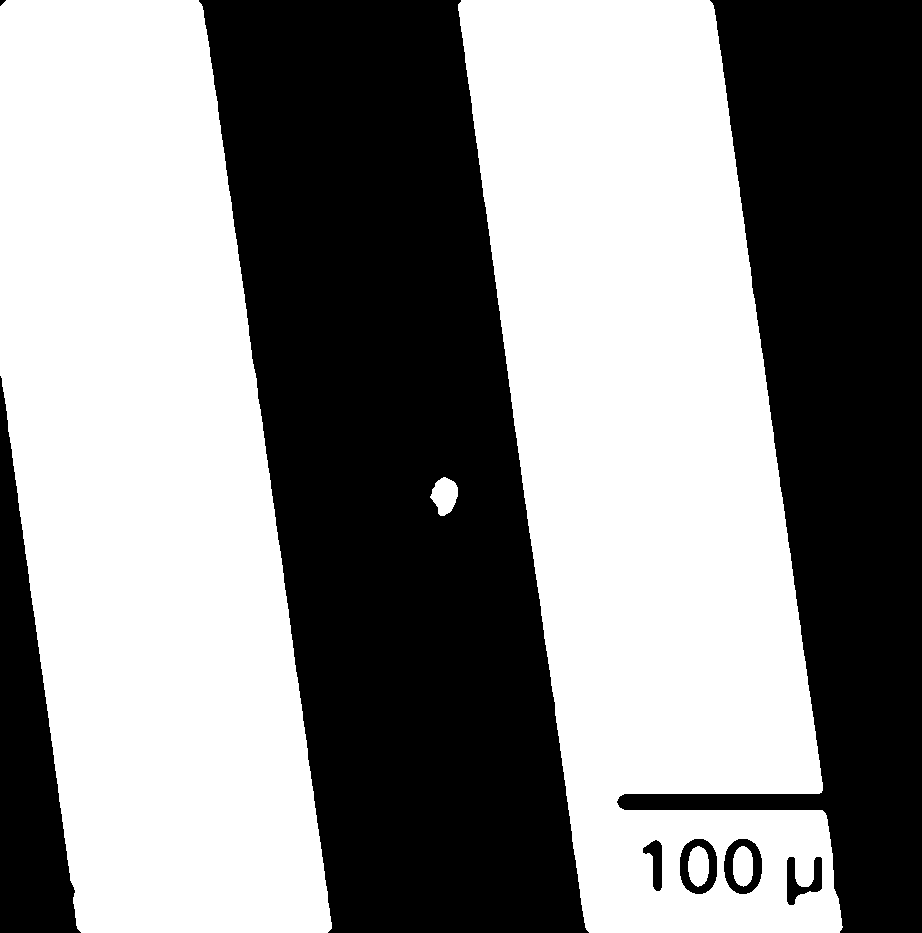

In [64]:
# Get etching result

# Input data
img_fp = 'D:/xie/etching/20240329/etched/image81.tif'
img_fp = 'D:/xie/etching/etching result/100um/image127.tif'
img_fp = 'paper/figure9.png'
img = cv.imread(img_fp)
from utils.computation import get_nms_Hough_lines

nms_lines, thresh = get_nms_Hough_lines(img)
#cv.imwrite('houghlines3.jpg',thresh)
cv.imshow('Hough lines',img)
cv.waitKey(0)
cv.destroyAllWindows()
Image.fromarray(thresh)
#

In [60]:
nms_lines

array([[-708.    ,    3.002 ],
       [-448.    ,    3.002 ],
       [-206.    ,    3.002 ],
       [  56.    ,    3.002 ],
       [ 798.    ,    1.5708],
       [ 840.    ,    1.5184]], dtype=float32)

In [62]:
from utils.computation import get_width_by_Hough_lines
get_width_by_Hough_lines(nms_lines, thresh)

(933, 922, 2) (826, 2)
Theta: 6.143558891611644; line gradient angle: -0.14205691355784314
(933, 922, 2) (862, 2)
Theta: 6.143558891611644; line gradient angle: 0.13548159890538872
Start
(933, 922, 2) (896, 2)
Theta: 6.143558891611644; line gradient angle: -0.14138231055223982
End
(933, 922, 2) (526, 2)
Theta: 3.0019662380218506; line gradient angle: 0.14593648946897222
Start
(933, 922, 2) (922, 2)
Theta: 1.5707963705062866; line gradient angle: 1.5706454553619222
Start
(933, 922, 2) (922, 2)
Theta: 1.5184364318847656; line gradient angle: -1.5202724100578184
Start


[242.0]

In [25]:
# Compute all etching widths
from utils.computation import get_nms_Hough_lines, get_width_by_Hough_lines
img_dir = 'D:/xie/etching/etching result/50um/'
#img_dir = 'D:/xie/etching/etching result/100um'
pattern_widths=[]

for img_fn in os.listdir(img_dir):
    img_fp = os.path.join(img_dir, img_fn)
    img = cv.imread(img_fp)
    extracted_width = []

    nms_lines, th = get_nms_Hough_lines(img)
    if nms_lines is not None:
        extracted_width = get_width_by_Hough_lines(nms_lines, th)
        print(extracted_width)
        
    pattern_widths += extracted_width
pattern_widths = np.array(pattern_widths)

[147.0, 145.0, 146.0]
[147.0, 147.0, 148.0]
[147.0, 145.0, 146.0]
[145.0, 145.0, 145.0]


KeyboardInterrupt: 

In [252]:
img_fp = 'D:/xie/etching/etching result/50um/image113.tif'
img = cv.imread(img_fp)
extracted_width = []

nms_lines, th = get_nms_Hough_lines(img)
if nms_lines is not None:
    extracted_width = get_width_by_Hough_lines(nms_lines, th)
    print(extracted_width)
    
pattern_widths += extracted_width

[129.0, 139.0]


In [253]:
img_fp = 'D:/xie/etching/etching result/50um/image235.tif'
img = cv.imread(img_fp)
extracted_width = []

nms_lines, th = get_nms_Hough_lines(img)
if nms_lines is not None:
    extracted_width = get_width_by_Hough_lines(nms_lines, th)
    print(extracted_width)
    
pattern_widths += extracted_width

[131.0, 121.0]


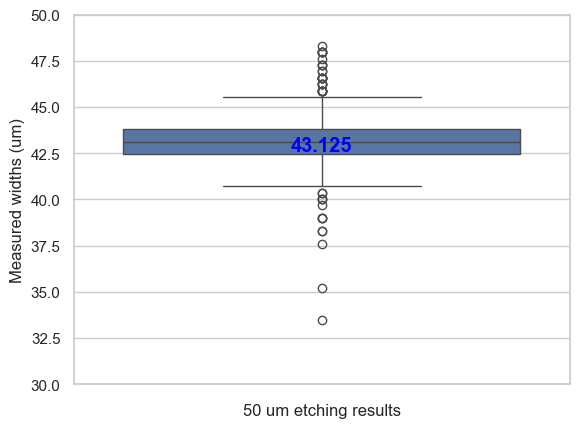

In [235]:
import seaborn as sns
import pandas as pd

um_per_pixel = 0.345
converted_pattern_widths = pattern_widths * um_per_pixel
sns.set(style='whitegrid')

box_plot = sns.boxplot(data=converted_pattern_widths)
box_plot.set_xlabel('50 um etching results')
box_plot.set_ylabel('Measured widths (um)')
box_plot.set_ylim(bottom=30, top=50)
for xtick in box_plot.get_xticks():
    box_plot.text(xtick,np.median(converted_pattern_widths) + -.5,np.median(converted_pattern_widths), 
            horizontalalignment='center',size='large',color='blue',weight='bold')

In [239]:
pattern_widths = np.array(pattern_widths)
pattern_widths = pattern_widths[np.where(pattern_widths!=0)]
pattern_widths = pattern_widths[np.where(pattern_widths!=None)]
pattern_widths = pattern_widths[np.where(pattern_widths>=40)]
pattern_widths = pattern_widths[np.where(pattern_widths<=45)]
print("Mean: {}, standard deviation: {}".format(pattern_widths.mean(), pattern_widths.std()))

Mean: nan, standard deviation: nan


C:\Users\Xian Du\AppData\Local\Temp\ipykernel_33944\3094503625.py:6: RuntimeWarning: Mean of empty slice.
  print("Mean: {}, standard deviation: {}".format(pattern_widths.mean(), pattern_widths.std()))
d:\xie\Vision\mcp_yolo\.venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
d:\xie\Vision\mcp_yolo\.venv\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
d:\xie\Vision\mcp_yolo\.venv\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
d:\xie\Vision\mcp_yolo\.venv\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


-0.08603265196858555
0.08726646


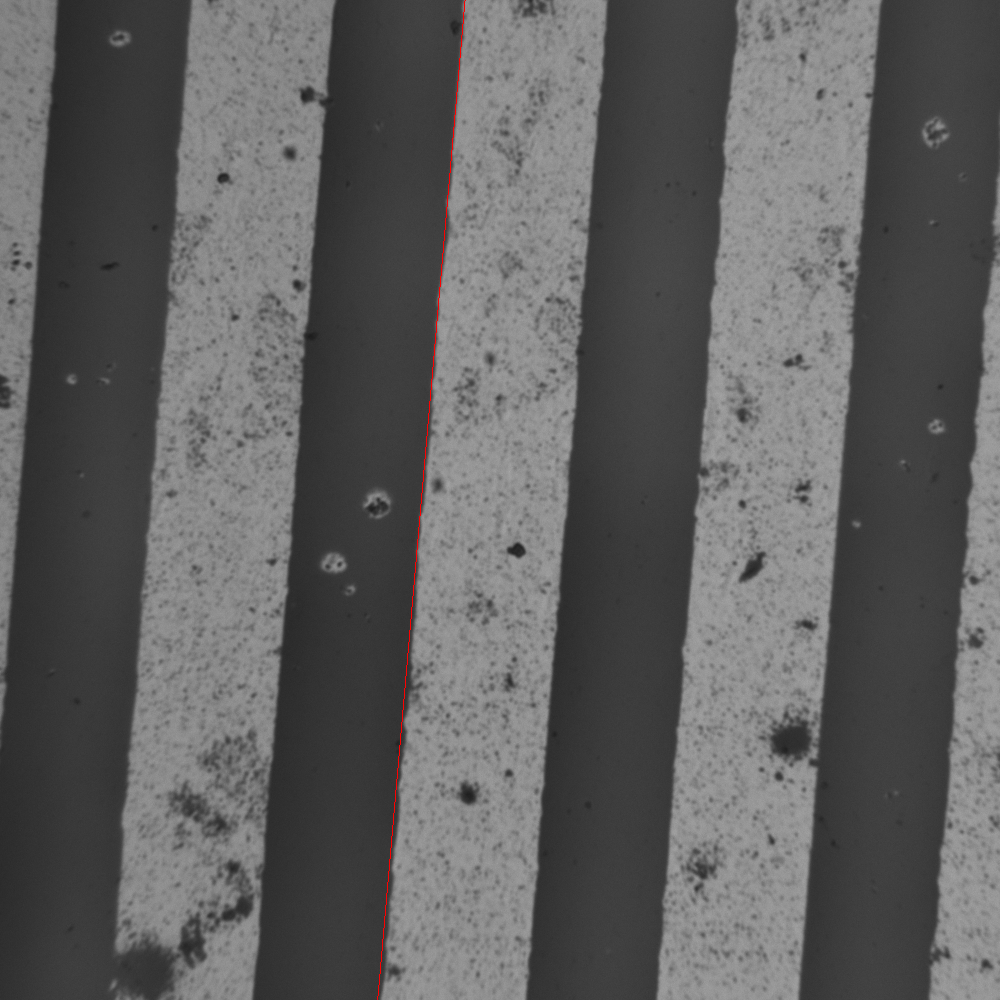

In [97]:
from skimage.draw import line
import sys
np.set_printoptions(suppress=True, precision=4)
orig_img = cv.imread(img_fp)
gradient_img = otsu_th
# sort the nms lines by rho
index = np.argsort(nms_lines[:,0])
nms_lines = nms_lines[index]
# compute the gradient of the image
mask_x = np.array([[-1,0,1]])
mask_y = mask_x.T
dx, dy = convolve2d(gradient_img, mask_x, mode='same'),  convolve2d(gradient_img, mask_y, mode='same')
#print(gradient_img[0,:50])
#print(dx[0,:50])
# set window size for ambient gradient computation
neiborhood_size = 11
neighborhood_mask = np.ones((neiborhood_size, neiborhood_size))
dx, dy = convolve2d(dx, neighborhood_mask, mode='same')[...,None],  convolve2d(dy, neighborhood_mask, mode='same')[...,None]
dx, dy = dx/neiborhood_size**2, dy/neiborhood_size**2
nabla_I = np.concatenate((dx, dy), axis=-1)
# get coordinates of pixels over the line
rho,theta = nms_lines[3]
a, b = np.cos(theta), np.sin(theta)
x0, y0 = a*rho,  b*rho
x1, y1 = int(x0 + width*(-b)), int(y0 + height*(a)) 
x2, y2 = int(x0 - width*(-b)), int(y0 - height*(a))
rr, cc = line(x1,y1,x2,y2)

coords = np.array(list(zip(cc,rr)))
# select coordinates within image
coords = coords[(coords >= 0).all(axis=-1)]
coords = coords[coords[:,0] < width]
coords = coords[coords[:,1] < height]
# compute dominant orientation of gradient
ambient_gradient = nabla_I[tuple(coords.T)].mean(axis=0)
print(-np.arctan(ambient_gradient[1]/ambient_gradient[0]))
print(np.arctan(np.sin(theta)/np.cos(theta)))
orig_img[tuple(coords.T)] = [255,0,0]
Image.fromarray(orig_img)

In [107]:
from utils.computation import get_width_by_Hough_lines
get_width_by_Hough_lines(nms_lines, otsu_th)

0.06929397712069381
0.08562297559902331
0.08655977954802722
0.08603265196858555
0.08773568180574111
0.08590928895712102
0.08699333192192961
0.08907072775469897


146.66667

In [ ]:
import torch
from torchvision.transforms.functional import affine

im1 = torch.rand(1, 100, 100, requires_grad=True)
angle1 = torch.tensor(100.0, requires_grad=True)
im2 = affine(img=im1, angle=angle1, translate=[1,2], scale=1.2,shear=10)
#im2 = torch.zeros_like(im1)
#translate=torch.tensor(1.0, requires_grad=True)
#translate = torch.nn.Parameter(translate)
#im2[int(translate):,:] = im1[:-int(translate),:]
loss = (im2-im1).sum()
print(loss)
loss.backward()
print(im1.grad)